In [1]:
from tools.Nth_Order_ECM import Nth_Order_ECM
from tools.tools import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from pathlib import Path
torch.manual_seed(1)
import time

In [2]:
# Model parameters
input_keys = ["soc","I","T"]
output_keys = ["V"]
cnn_batch_size = 128
lstm_batch_size = 32
lstm_sequence_length = 4
cnn_sequence_length = 2
cnn_num_layers = 4
lstm_num_layers = 2
cnn_num_neurons = 164
lstm_hidden_size = 207

# Set the device used for running the NN models
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Empty RMSE dictionary
rmse_dic = {"ecm":{},"cnn":{},"lstm":{}}

# Empty time dictionary to store the execution times of the models on the FUDS datasets
execution_time = {
    "repeat":5,
    "ecm":{"cpu":{"fuds":[]}},
    "cnn":{"cpu":{"fuds":[]},"cuda":{"fuds":[]}},
    "lstm":{"cpu":{"fuds":[]},"cuda":{"fuds":[]}}
    }

# Load CNN best model
cnn_model = CNN_model(num_layers=cnn_num_layers, 
                      num_neurons=cnn_num_neurons, 
                      sequence_length=cnn_sequence_length, 
                      input_keys=input_keys, 
                      output_keys=output_keys)
cnn_model.load_state_dict(torch.load("data/best_cnn_ecm_trained.pth"))

# Load LSTM best model
lstm_model = LSTM_model(input_size=len(input_keys), 
                        hidden_size=lstm_hidden_size, 
                        num_layers=lstm_num_layers, 
                        output_size=len(output_keys))
lstm_model.load_state_dict(torch.load("data/best_lstm_ecm_trained.pth"))

# Load matlab file data to compare both of the NN performance
# First we load the min_max_dict used to scale the training data
with open(Path("data/data.bin"), "rb") as f:
    # Load the pickled data
    _ = pickle.load(f)
_ = flatten_dict(_)
_, min_max_dict = scale_dict(_)
# Use the min_max_data to scale the measurements of the matlab file
data_lad, data_ela = format_LGHE4C25B01(min_max_dict,constant_temperature=True)
datasets = {"lad": data_lad, "ela": data_ela}

c:\Users\Bouraoui\Documents\Job\ecm_lstm_cnn\tools\tools.py:892: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(input, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)


Plots at temperature T=15


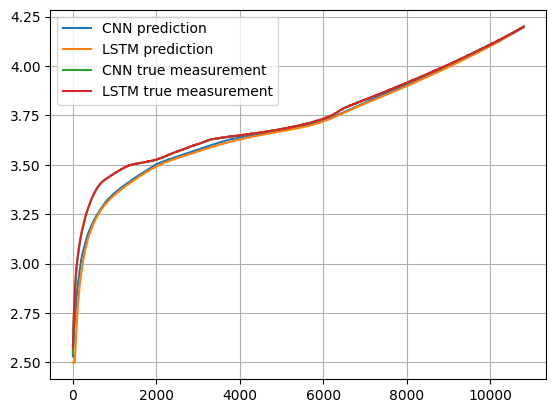

Plots at temperature T=25


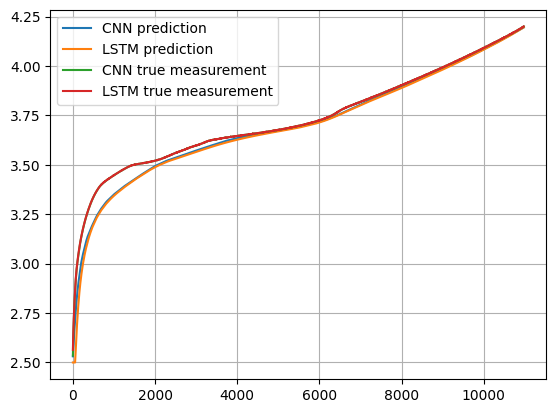

Plots at temperature T=45


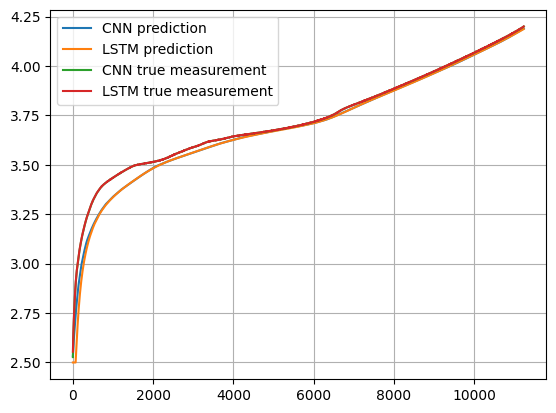

Plots at temperature T=15


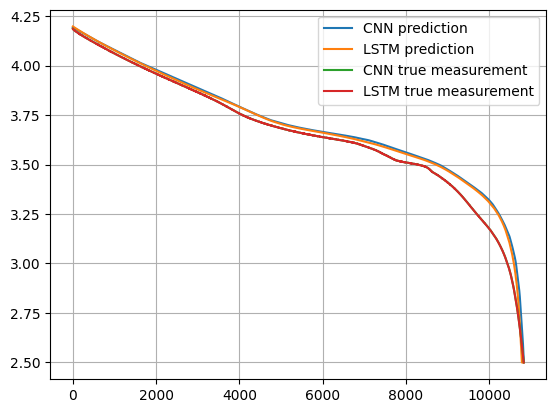

Plots at temperature T=25


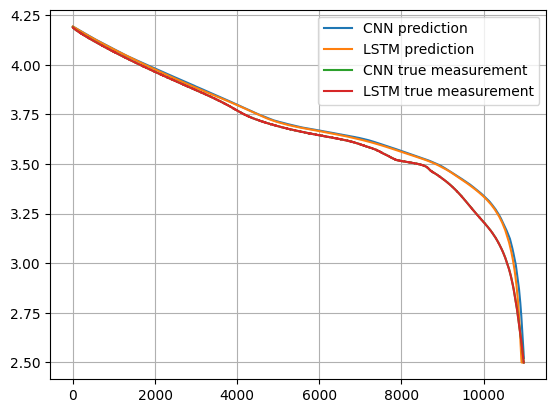

Plots at temperature T=45


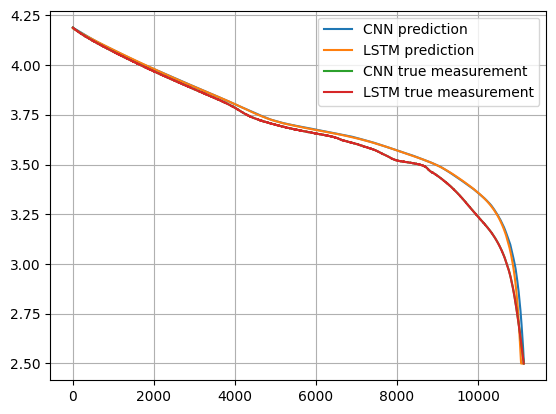

In [3]:
# Test LSTM and CNN on charge discharge data
# The models are run on the GPU
lstm_mse = {}
cnn_mse = {}
max_voltage = min_max_dict["V"][1]
min_voltage = min_max_dict["V"][0]
eoc = 4.2
eod = 2.5


# Move models to device
cnn_model.to(device=device)
lstm_model.to(device=device)
for set_name, dataset in datasets.items():
    lstm_mse.update({set_name:{}})
    cnn_mse.update({set_name:{}})
    rmse_dic["cnn"].update({set_name:{}})
    rmse_dic["lstm"].update({set_name:{}})
    for key, value in dataset.items():
        # Create the custom datasets for both NNs
        lstm_dataset = LSTM_dataset(value, 
                                         sequence_length=lstm_sequence_length,
                                         input_keys=input_keys,
                                         output_keys=output_keys)
        cnn_formatted_data = []
        CNN_1D_data_format(sub_dic=value, formatted_data=cnn_formatted_data, sequence_length=cnn_sequence_length)
        cnn_dataset = CNN_1D_dataset(cnn_formatted_data)
        
        # Test the NNs on their respective custom dataset
        cnn_test_loss, cnn_prediction, cnn_true_measurement = test_model(model=cnn_model,
                                                                        batch_size=cnn_batch_size,
                                                                        test_set=cnn_dataset,
                                                                        device=device,
                                                                        return_prediction=True)
        
        lstm_test_loss, lstm_prediction, lstm_true_measurement = test_model(model=lstm_model,
                                                                        batch_size=lstm_batch_size,
                                                                        test_set=lstm_dataset,
                                                                        device=device,
                                                                        return_prediction=True)

        # Unscale predictions and true measurments
        cnn_prediction = np.array(cnn_prediction)*(max_voltage-min_voltage)+min_voltage
        lstm_prediction = np.array(lstm_prediction)*(max_voltage-min_voltage)+min_voltage
        cnn_true_measurement = np.array(cnn_true_measurement)*(max_voltage-min_voltage)+min_voltage
        lstm_true_measurement = np.array(lstm_true_measurement)*(max_voltage-min_voltage)+min_voltage
        
        # The output of the LSTM is sometimes out of the range [eod, eoc]. We are going to force the limits
        lstm_prediction = np.clip(lstm_prediction, eod, eoc)
        
        # Calculate the MSE for each data point and store them in the dictionaries
        # For visualisation purposes, the predction and true measurement need to be on the same scale 
        
        rmse_dic["cnn"][set_name].update({key:rmse(cnn_prediction, cnn_true_measurement)})
        rmse_dic["lstm"][set_name].update({key:rmse(lstm_prediction, lstm_true_measurement)})

       
        # plot the predictions and their respective true measurement
        print(f"Plots at temperature T={key}")
        plt.plot(cnn_prediction, label="CNN prediction")
        plt.plot(lstm_prediction, label="LSTM prediction")
        plt.plot(cnn_true_measurement, label="CNN true measurement")
        plt.plot(lstm_true_measurement, label="LSTM true measurement")
        plt.legend()
        plt.grid()
        plt.show()

In [4]:
rmse_dic

{'ecm': {},
 'cnn': {'lad': {'15': 0.04555261, '25': 0.04469861, '45': 0.044258423},
  'ela': {'15': 0.06075212, '25': 0.05897349, '45': 0.05548657}},
 'lstm': {'lad': {'15': 0.060852718, '25': 0.05921455, '45': 0.05916665},
  'ela': {'15': 0.052109655, '25': 0.05179213, '45': 0.05072993}}}

In [5]:
_,_,ecm_param_mean = load_data_LGHE4C25B01_Parameter() # load ecm mean parameter
data_lad, data_ela = load_data_LGHE4C25B01() # load charge-discharge data
datasets = {"lad": data_lad, "ela": data_ela} # store charge-discharge data in dictionary
log = {"lad":{}, "ela":{}} # log dictionary for the charge-discharge results


for set_name, dataset in datasets.items():
    rmse_dic["ecm"].update({set_name:{}})
    for key, value in dataset.items():
        f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T=key)
        dt = np.abs(dataset[key]["Ah"][10]-dataset[key]["Ah"][9])/np.abs(dataset[key]["I"][0]) # extract the time step for the ecm
        C_ref = np.mean(dataset[key]["Cap"]) # Total battery capacity
        soc_init = dataset[key]["Ah"][0]/dataset[key]["Cap"][0]
        U = dataset[key]["U"]
        I = dataset[key]["I"]
        bm = Nth_Order_ECM(R0=f["R0"], 
                       Rs=[f["R1"],f["R2"]],
                       Taus=[f["Tau1"],f["Tau2"]],
                       ocv_grid=f["ocv_grid"],
                       C_ref=C_ref,
                       soc_init=soc_init, 
                       ts=dt)
        log[set_name].update({key:simulate_ecm(ecm=bm, current=I)})
        rmse_dic["ecm"][set_name].update({key:rmse(log[set_name][key]["V"], U)})

C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\2960902945.py:10: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T=key)
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\2960902945.py:10: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T=key)
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\2960902945.py:10: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T=key)
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\2960902945.py:10: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T=key)
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\2960902945.py:10: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T=key)
C:\Users\Bouraoui\AppData\Local\Tem

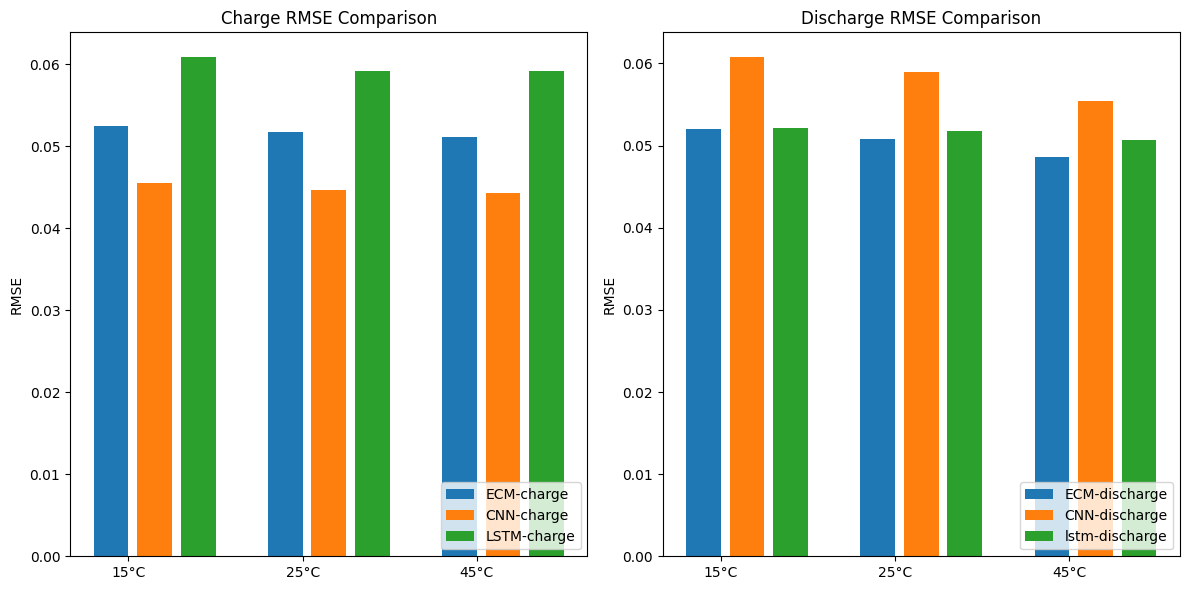

In [6]:
# Data
temperatures = ['15°C', '25°C', '45°C']
ecm_lad = [rmse_dic['ecm']['lad']['15'], rmse_dic['ecm']['lad']['25'], rmse_dic['ecm']['lad']['45']]
ecm_ela = [rmse_dic['ecm']['ela']['15'], rmse_dic['ecm']['ela']['25'], rmse_dic['ecm']['ela']['45']]
cnn_lad = [rmse_dic['cnn']['lad']['15'], rmse_dic['cnn']['lad']['25'], rmse_dic['cnn']['lad']['45']]
cnn_ela = [rmse_dic['cnn']['ela']['15'], rmse_dic['cnn']['ela']['25'], rmse_dic['cnn']['ela']['45']]
lstm_lad = [rmse_dic['lstm']['lad']['15'], rmse_dic['lstm']['lad']['25'], rmse_dic['lstm']['lad']['45']]
lstm_ela = [rmse_dic['lstm']['ela']['15'], rmse_dic['lstm']['ela']['25'], rmse_dic['lstm']['ela']['45']]

# Plot the bar plots
x = np.arange(len(temperatures))
width = 0.2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Charge RMSE Comparison
axs[0].bar(x - 0.5*width, ecm_lad, width, label='ECM-charge')
axs[0].bar(x + 0.75*width, cnn_lad, width, label='CNN-charge')
axs[0].bar(x + 2*width, lstm_lad, width, label='LSTM-charge')
axs[0].set_ylabel('RMSE')
axs[0].set_title('Charge RMSE Comparison')
axs[0].set_xticks(x)
axs[0].set_xticklabels(temperatures)
axs[0].legend(loc="lower right")

# Discharge RMSE Comparison
axs[1].bar(x - 0.5*width, ecm_ela, width, label='ECM-discharge')
axs[1].bar(x + 0.75*width, cnn_ela, width, label='CNN-discharge')
axs[1].bar(x + 2*width, lstm_ela, width, label='lstm-discharge')
axs[1].set_ylabel('RMSE')
axs[1].set_title('Discharge RMSE Comparison')
axs[1].set_xticks(x)
axs[1].set_xticklabels(temperatures)
axs[1].legend(loc="lower right")

# Adjust the layout
plt.tight_layout()

# Save fig
# plt.savefig("rmse_charge_discharge_cnn_lstm_ecm.pdf")

# Show the plots
plt.show()


C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\453580990.py:24: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\453580990.py:24: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\453580990.py:24: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\453580990.py:24: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Temp\ipykernel_16812\453580990.py:24: RankWarning: Polyfit may be poorly conditioned
  f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
C:\Users\Bouraoui\AppData\Local\Tem

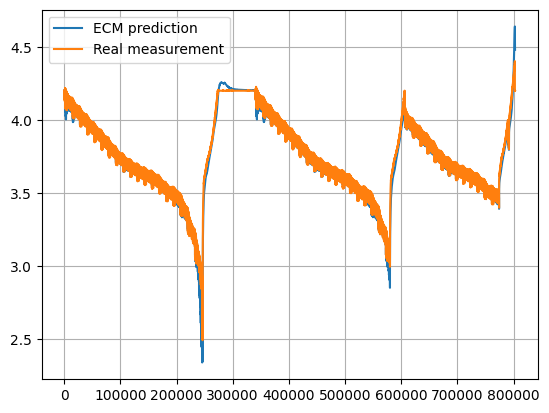

In [7]:
# Load the FUDS csv file
fuds = pd.read_csv("data/LGHE4_data/HE4C25B01_MultiFUDS_25dg_fan_startS5_NormTab.csv")

# Extract the relevant data for the ECM and the NNs:
# Extract time step dt (here the average time step)
dt = np.mean(np.diff(fuds["Test_Time"].values.astype(np.float32)))

# Extract the Current array
I = fuds["Current"].values.astype(np.float32)

# Extract maximum capacity of the battery
C_ref = 2.5# np.max(fuds["Charge_Capacity"].values.astype(np.float32))

# Extract the SOC array: (charge capacity array)/max charge capacity
soc = fuds["Charge_Capacity"].values.astype(np.float32)/C_ref

# Create temperature array (the name of the csv file has 25dg in it. So I suppose T= 25°C)
T = np.ones(np.shape(I))*25.0

# Extract the terminal voltage array
U = fuds["Voltage"].values.astype(np.float32)

# Simulate ECM
f = interpolate_ecm_parameter(ecm_param_mean, deg=20, plot=False, T="25")
fuds_log = None
for _ in range(1): # range(execution_time["repeat"]):
    bm = Nth_Order_ECM(R0=f["R0"], 
                       Rs=[f["R1"],f["R2"]],
                       Taus=[f["Tau1"],f["Tau2"]],
                       ocv_grid=f["ocv_grid"],
                       C_ref=C_ref*3600,
                       soc_init=1, 
                       ts=dt)
    start_time = time.perf_counter()
    fuds_log = simulate_ecm(ecm=bm, current=I)
    end_time = time.perf_counter()
    execution_time["ecm"]["cpu"]["fuds"].append(end_time-start_time)

plt.plot(fuds_log["V"], label="ECM prediction")
plt.plot(U, label="Real measurement")
plt.legend()
plt.grid()
plt.show()


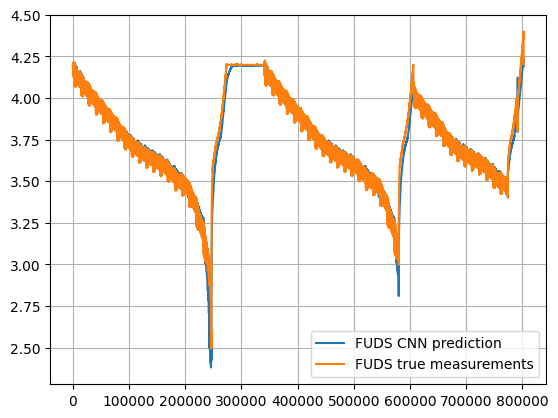

In [8]:
# CNN: FUDS simulation run on CPU
device = "cpu"
min_temperature = min_max_dict["T"][0]
max_temperature = min_max_dict["T"][1]
fuds_scaled_voltage = (U-min_voltage)/(max_voltage-min_voltage)
fuds_scaled_temperature = (T-min_temperature)/(max_temperature-min_temperature)
fuds_cnn_dict = {"soc":fuds_log["SOC"],
                 "I":I,
                 "T":fuds_scaled_temperature,
                 "V":fuds_scaled_voltage}

fuds_cnn_list = []
CNN_1D_data_format(sub_dic=fuds_cnn_dict,
                   formatted_data=fuds_cnn_list,
                   sequence_length=cnn_sequence_length)

fuds_cnn_dataset = CNN_1D_dataset(fuds_cnn_list,input_keys=["soc","I","T"]) 
cnn_model.to(device)

cnn_test_loss, cnn_prediction, cnn_true_measurement = None, None, None
for _ in range(execution_time["repeat"]):
    start_time = time.perf_counter()
    cnn_test_loss, cnn_prediction, cnn_true_measurement = test_model(model=cnn_model,
                                                                        batch_size=cnn_batch_size,
                                                                        test_set=fuds_cnn_dataset,
                                                                        device=device,
                                                                        return_prediction=True)
    end_time = time.perf_counter()
    execution_time["cnn"][device]["fuds"].append(end_time-start_time)
# Unscale predictions and true measurments
cnn_prediction = np.array(cnn_prediction)*(max_voltage-min_voltage)+min_voltage
cnn_true_measurement = np.array(cnn_true_measurement)*(max_voltage-min_voltage)+min_voltage

# Plot results
plt.plot(cnn_prediction, label="FUDS CNN prediction")
plt.plot(cnn_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

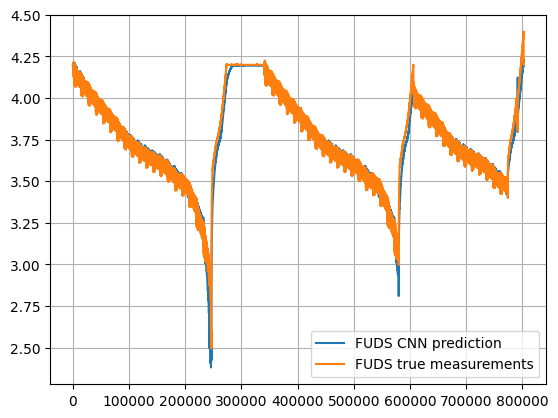

In [9]:
# CNN: FUDS simulation on GPU
device = "cuda"
min_temperature = min_max_dict["T"][0]
max_temperature = min_max_dict["T"][1]
fuds_scaled_voltage = (U-min_voltage)/(max_voltage-min_voltage)
fuds_scaled_temperature = (T-min_temperature)/(max_temperature-min_temperature)
fuds_cnn_dict = {"soc":fuds_log["SOC"],
                 "I":I,
                 "T":fuds_scaled_temperature,
                 "V":fuds_scaled_voltage}

fuds_cnn_list = []
CNN_1D_data_format(sub_dic=fuds_cnn_dict,
                   formatted_data=fuds_cnn_list,
                   sequence_length=cnn_sequence_length)

fuds_cnn_dataset = CNN_1D_dataset(fuds_cnn_list,input_keys=["soc","I","T"]) 
cnn_model.to(device)
cnn_test_loss, cnn_prediction, cnn_true_measurement = None, None, None
for _ in range(execution_time["repeat"]):
    start_time = time.perf_counter()
    cnn_test_loss, cnn_prediction, cnn_true_measurement = test_model(model=cnn_model,
                                                                        batch_size=cnn_batch_size,
                                                                        test_set=fuds_cnn_dataset,
                                                                        device=device,
                                                                        return_prediction=True)
    end_time = time.perf_counter()
    execution_time["cnn"][device]["fuds"].append(end_time-start_time)
# Unscale predictions and true measurments
cnn_prediction = np.array(cnn_prediction)*(max_voltage-min_voltage)+min_voltage
cnn_true_measurement = np.array(cnn_true_measurement)*(max_voltage-min_voltage)+min_voltage

# Plot results
plt.plot(cnn_prediction, label="FUDS CNN prediction")
plt.plot(cnn_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

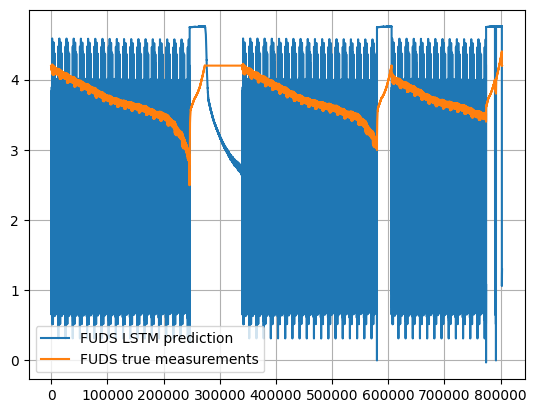

In [10]:
# LSTM: FUDS simulation on GPU
device = "cuda"
fuds_lstm_dict = {"soc":fuds_log["SOC"],
                     "I":I,
                     "T":fuds_scaled_temperature,
                     "V":fuds_scaled_voltage}

fuds_lstm_dataset = LSTM_dataset(dic=fuds_lstm_dict,
                                 sequence_length=lstm_sequence_length)
lstm_model.to(device)

lstm_test_loss, lstm_prediction, lstm_true_measuremen = None, None, None
for _ in range(execution_time["repeat"]):
    start_time = time.perf_counter()
    lstm_test_loss, lstm_prediction, lstm_true_measurement = test_model(model=lstm_model,
                                                                        batch_size=lstm_batch_size,
                                                                        test_set=fuds_lstm_dataset,
                                                                        device=device,
                                                                        return_prediction=True)
    end_time = time.perf_counter()
    execution_time["lstm"][device]["fuds"].append(end_time-start_time)

lstm_prediction = np.array(lstm_prediction)*(max_voltage-min_voltage)+min_voltage
lstm_true_measurement = np.array(lstm_true_measurement)*(max_voltage-min_voltage)+min_voltage


plt.plot(lstm_prediction, label="FUDS LSTM prediction")
plt.plot(lstm_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

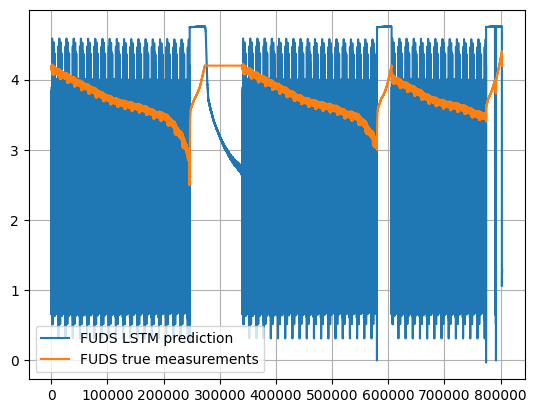

In [11]:
# LSTM: FUDS simulation on CPU
device = "cpu"
fuds_lstm_dict = {"soc":fuds_log["SOC"],
                     "I":I,
                     "T":fuds_scaled_temperature,
                     "V":fuds_scaled_voltage}

fuds_lstm_dataset = LSTM_dataset(dic=fuds_lstm_dict,
                                 sequence_length=lstm_sequence_length)
lstm_model.to(device)
for _ in range(execution_time["repeat"]):
    start_time = time.perf_counter()
    lstm_test_loss, lstm_prediction, lstm_true_measurement = test_model(model=lstm_model,
                                                                        batch_size=lstm_batch_size,
                                                                        test_set=fuds_lstm_dataset,
                                                                        device=device,
                                                                        return_prediction=True)
    end_time = time.perf_counter()
    execution_time["lstm"][device]["fuds"].append(end_time-start_time)

lstm_prediction = np.array(lstm_prediction)*(max_voltage-min_voltage)+min_voltage
lstm_true_measurement = np.array(lstm_true_measurement)*(max_voltage-min_voltage)+min_voltage


plt.plot(lstm_prediction, label="FUDS LSTM prediction")
plt.plot(lstm_true_measurement, label="FUDS true measurements")
plt.grid()
plt.legend()
plt.show()

In [12]:
print(f"LSTM RMSE {rmse(lstm_true_measurement,lstm_prediction)}")
print(f"CNN RMSE {rmse(cnn_true_measurement,cnn_prediction)}")
print(f"ECM RMSE {rmse(fuds_log['V'],U)}")

LSTM RMSE 1.9530746936798096
CNN RMSE 0.045010633766651154
ECM RMSE 0.039258992917425385


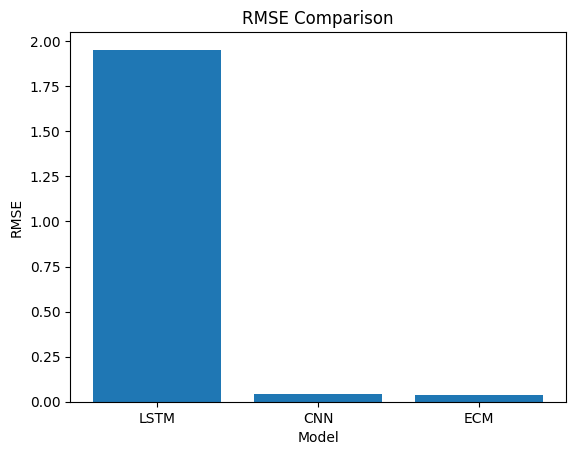

In [13]:
# RMSE values
lstm_rmse = rmse(lstm_true_measurement, lstm_prediction)
cnn_rmse = rmse(cnn_true_measurement, cnn_prediction)
ecm_rmse = rmse(fuds_log['V'], U)

# Data
models = ['LSTM', 'CNN', 'ECM']
rmse_values = [lstm_rmse, cnn_rmse, ecm_rmse]

# Create the bar plot
plt.bar(models, rmse_values)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
# plt.savefig("lstm_cnn_ecm_rmse_fuds_trained.pdf")
plt.show()


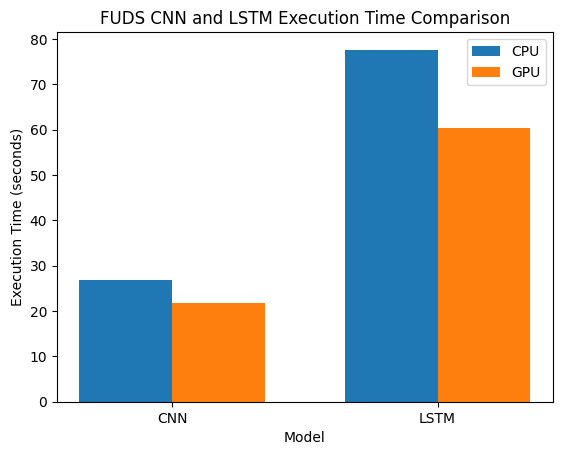

In [14]:
# Data
execution_time_cpu = [np.mean(execution_time["cnn"]["cpu"]["fuds"]), np.mean(execution_time["lstm"]["cpu"]["fuds"])]
execution_time_gpu = [np.mean(execution_time["cnn"]["cuda"]["fuds"]), np.mean(execution_time["lstm"]["cuda"]["fuds"])]
models = ['CNN', 'LSTM']
labels = ['CPU', 'GPU']

# Plot the bar plot
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, execution_time_cpu, width, label='CPU')
ax.bar(x + width/2, execution_time_gpu, width, label='GPU')
ax.set_xlabel('Model')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('FUDS CNN and LSTM Execution Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Save fig
# plt.savefig("execution_time_fuds_cnn_lstm_gpu_cpu.pdf")

# Show the plot
plt.show()